In [ ]:
!pip install datasets==3.6.0



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.7.0 requires fsspec==2025.7.0, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [ ]:
import random
import re
import torch
from collections import Counter
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
)
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from huggingface_hub import login
import torch


In [ ]:
from huggingface_hub import login

# Paste your Hugging Face token here
login(token="...")

In [ ]:
# Load dataset
from datasets import load_dataset
import random

# Load a larger portion first
full_validation = load_dataset("hatexplain", split="validation", trust_remote_code=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

hatexplain.py: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/15383 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1922 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1924 [00:00<?, ? examples/s]

In [ ]:
dataset = full_validation.select(range(950, 1050))  # upper bound is exclusive


# Sample 3 few-shot examples
fewshot_data = random.sample(list(dataset), 3)

In [1]:
import os
# Paste your GOOGLE API KEY here

os.environ["GOOGLE_API_KEY"] = "..."


In [ ]:
import google.generativeai as genai

genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

model = genai.GenerativeModel("gemini-2.5-pro")


In [ ]:
label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

def normalize_labels(labels):
    return [label_map[l] if isinstance(l, int) else l for l in labels]

def majority_label(label_list):
    from collections import Counter
    return label_map[Counter(label_list).most_common(1)[0][0]]

def format_gemini_prompt(test_text, fewshot_data=None):
    prompt = (
        "This prompt is part of a research project on AI-based content moderation. "
    "You are a moderation engine. Classify the following text into one of three categories: "
    "normal: No harmful intent. May contain vulgarity or references to race, religion, gender, etc., but does not attack or insult."
    "-offensive: Uses strong language or insults, possibly directed at an individual, but not hateful toward a group."
    "hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc."
    "Respond in JSON format: {\"label\": \"<normal|offensive|hatespeech>\", \"explanation\": \"<short reason>\"}\n\n"
    "Text: \"{}\""

    )
    if fewshot_data:
        prompt += "Use the following definitions:\n"
        "Important instructions:"
        "- **DO NOT** mark speech as offensive or hatespeech *just because it references race, religion, gender, or politics*. These may be part of a factual or provocative discussion."
        "- Mark as normal if the content reflects opinion, debate, or neutral statement—even if it touches on sensitive themes—**as long as it does not insult, or incite hate."
        "- Annotators may label many such examples as normal. Match their judgment unless clear reasons justify otherwise."

        for sample in fewshot_data:
            example_text = " ".join(sample["post_tokens"])
            label = majority_label(sample["annotators"]["label"])
            prompt += f'User: {example_text}\nAssistant:\n{{"label": "{label}"}}\n\n'

    prompt += f"User: {test_text}\nAssistant:\n"
    return prompt


In [ ]:
def format_gemini_prompt(test_text, fewshot_data=None):
    prompt = (
        "This prompt is part of a research project on AI-based content moderation.\n"
        "You are a content moderation engine classifying online posts as:\n"
       "You are a moderation engine for a social media. Classify the following text from users of social media from twitter and Gab into one of three categories: "
    "normal: No harmful intent. May contain vulgarity or references to race, religion, gender, etc., but does not attack or insult."
    "-offensive: Uses strong language or insults, possibly directed at an individual, but not hateful toward a group."
        "hatespeech: Attacks, dehumanizes, or incites hatred against a group based on race, religion, gender, etc."
        "Respond only in the following JSON format:\n"
        '{"label": "<normal|offensive|hatespeech>", "explanation": "<brief reason>"}\n\n'
         "If you are uncertain or hesitant, add this line:"
          "SECOND PASS: Please reconsider briefly."
           )

    if fewshot_data:
        prompt += "Additional few-shot examples from the dataset:\n"
        "Important instructions:\n"
        "- Do NOT classify something as offensive or hatespeech just for mentioning race, religion, gender, or politics.\n"
        "- Sarcasm, criticism, or complex social commentary should be marked as 'normal' unless they clearly target or insult.\n\n"
        "Respond only in the following JSON format:\n"
        '{"label": "<normal|offensive|hatespeech>", "explanation": "<brief reason>"}\n\n'
        "If it's between normal and hatespeech, the moderation is very lenient towards hatespeech, so if it's not so violent put it in normal"
        "If it's between normal and offensive, the moderation is very lenient towards offensive, so if it's not so violent put it in normal"
        "If it's between offensive and hatespeech, what matters is really if there's a target and how the target is treated, if it incites hate, then it is hatespeech"
        "Examples:\n\n"
        'User: "I don\'t think black people should pay more in taxes."\n'
        'Assistant:\n{"label": "normal", "explanation": "Social commentary; not hateful or offensive."}\n\n'
        'User: "The government helps Jews but not us."\n'
        'Assistant:\n{"label": "normal", "explanation": "Perceived inequality claim; not hateful."}\n\n'
        'User: "You dumb b*tch, shut up already."\n'
        'Assistant:\n{"label": "offensive", "explanation": "Insulting and disrespectful language."}\n\n'
        'User: "Muslims are evil and should be banned."\n'
        'Assistant:\n{"label": "hatespeech", "explanation": "Promotes hatred against a group."}\n\n'

        for sample in fewshot_data:
            example_text = " ".join(sample["post_tokens"])
            label = majority_label(sample["annotators"]["label"])
            prompt += f'User: "{example_text}"\nAssistant:\n{{"label": "{label}"}}\n\n'

    prompt += f'User: "{test_text}"\nAssistant:\n'
    return prompt


In [ ]:
def run_gemini_inference(dataset, fewshot_data=None):
    results = []
    for sample in dataset:
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text, fewshot_data=fewshot_data)
        response = model.generate_content(prompt)
        result = response.text
        results.append({"generated_text": result})
    return results


In [ ]:
import re

def extract_label_from_text(text):
        # Match **Label:** line
        matches = re.findall(r"\*\*label:\*\*\s*(hatespeech|normal|offensive)", text.lower())
        if matches:
            return matches[-1]
        # Fallback to JSON
        fallback = re.findall(r'"label"\s*:\s*"?(hatespeech|normal|offensive)"?', text.lower())
        if fallback:
            return fallback[-1]
        return "unknown"


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def majority_label(label_list):
    count = Counter(label_list)
    return count.most_common(1)[0][0]

def plot_confusion_matrix(dataset, preds):
    label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
    id_to_label = {0: "hatespeech", 1: "normal", 2: "offensive"}
    label_order = ["hatespeech", "normal", "offensive" ]

    golds = [label_map[majority_label(sample["annotators"]["label"])] for sample in dataset]

    cm = confusion_matrix(golds, preds, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)

    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()



In [ ]:
# Global state to track where we left off


In [ ]:
def run_gemini_in_chunks(dataset, fewshot_data=None, chunk_size=10, temperature=0.2):
    global gemini_run_index

    if gemini_run_index >= len(dataset):
        print("✅ All samples have been processed.")
        return []

    end_index = min(gemini_run_index + chunk_size, len(dataset))
    chunk = list(dataset.select(range(gemini_run_index, end_index)))

    results = []
    for sample in chunk:
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text, fewshot_data=fewshot_data)
        response = model.generate_content(
            prompt,
            generation_config={
                "temperature": temperature,
            }
        )
        result = response.text
        results.append({"generated_text": result})

    print(f"✅ Processed samples {gemini_run_index} to {end_index - 1} with temperature={temperature}")
    gemini_run_index = end_index
    return results


In [ ]:
def run_gemini_in_chunks(dataset, fewshot_data=None, chunk_size=5, temperature=0.2):
    global gemini_run_index

    if gemini_run_index >= len(dataset):
        print("✅ All samples have been processed.")
        return []

    end_index = min(gemini_run_index + chunk_size, len(dataset))
    chunk = list(dataset.select(range(gemini_run_index, end_index)))

    results = []
    for sample in chunk:
        text = " ".join(sample["post_tokens"])
        prompt = format_gemini_prompt(text)

        # First pass
        response = model.generate_content(
            prompt,
            generation_config={
                "temperature": temperature}
        )
        result_text = response.text

        # If the model is uncertain, request second pass
        if "SECOND PASS" in result_text:
            print("🔁 Re-prompting for second pass due to uncertainty...")
            second_prompt = result_text + "\nPlease reconsider and respond again in JSON format."
            second_response = model.generate_content(
                second_prompt,
                generation_config={
                    "temperature": temperature}
            )
            result_text = second_response.text

        results.append({"generated_text": result_text})

    print(f"✅ Processed samples {gemini_run_index} to {end_index - 1} with temperature={temperature}")
    gemini_run_index = end_index
    return results


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_outputs(dataset, outputs):
    preds = [extract_label_from_text(x["generated_text"]) for x in outputs]

    golds_majority = [
        label_map[Counter(sample["annotators"]["label"]).most_common(1)[0][0]]
        for sample in dataset.select(range(len(preds)))
    ]

    # Custom accuracy: prediction ∈ any annotator's labels
    match_any_annotator = []
    for sample, pred in zip(dataset.select(range(len(preds))), preds):
        annotator_labels = [label_map[l] for l in sample["annotators"]["label"]]
        match_any_annotator.append(int(pred in annotator_labels))

    custom_acc = sum(match_any_annotator) / len(preds)

    # Final reporting
    print("Accuracy (majority gold):", accuracy_score(golds_majority, preds))
    print("Macro-F1:                ", f1_score(golds_majority, preds, average="macro"))
    print("Custom Accuracy (any annotator agrees):", round(custom_acc, 3))



In [ ]:
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}
label_order = ["hatespeech", "normal", "offensive" ]


def plot_confusion_matrix_from_outputs(dataset, outputs):
    preds = [extract_label_from_text(x["generated_text"]) for x in outputs]

    golds = [
        label_map[
            Counter(sample["annotators"]["label"]).most_common(1)[0][0]
        ]
        for sample in dataset.select(range(len(preds)))
    ]

    cm = confusion_matrix(golds, preds, labels=label_order)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_order)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
import random
import re
from collections import Counter

label_map = {0: "hatespeech", 1: "normal", 2: "offensive"}

def extract_label_and_explanation(text):
    label_match = re.search(r'"label"\s*:\s*"?(normal|offensive|hatespeech)"?', text.lower())
    explanation_match = re.search(r'"explanation"\s*:\s*"([^"]+)"', text)

    label = label_match.group(1) if label_match else "unknown"
    explanation = explanation_match.group(1) if explanation_match else "(no explanation found)"
    return label, explanation

def print_sample_info(dataset, outputs, index=None, label=None):
    if label:
        # Search for a random sample with that predicted label
        matches = [
            i for i, out in enumerate(outputs)
            if extract_label_and_explanation(out["generated_text"])[0] == label
        ]
        if not matches:
            print(f"❌ No predicted samples found with label '{label}'")
            return
        index = random.choice(matches)
        print(f"🎯 Random sample with predicted label '{label}': index {index}")

    if index is None or index >= len(outputs):
        print(f"❌ Invalid index: {index}")
        return

    sample = dataset[index]
    output_text = outputs[index]["generated_text"]
    text_input = " ".join(sample["post_tokens"])

    # Get true labels
    raw_labels = sample["annotators"]["label"]
    label_strings = [label_map[l] for l in raw_labels]
    majority = Counter(label_strings).most_common(1)[0][0]

    # Extract prediction
    pred_label, explanation = extract_label_and_explanation(output_text)

    # --- Print everything ---
    print(f"\n📄 Input Text (Sample #{index}):\n{text_input}\n")
    print("🧠 Full Model Output:\n" + output_text + "\n")
    print("🔎 Extracted Prediction:")
    print(f"   Label       : {pred_label}")
    print(f"   Explanation : {explanation}\n")
    print("🧑‍⚖️ Annotator Labels:")
    print(f"   Numeric     : {raw_labels}")
    print(f"   Mapped      : {label_strings}")
    print(f"   Majority    : {majority}")


In [ ]:
outputs = []
gemini_run_index = 0
temp=0.2
chunk=5

In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 0 to 4 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 5 to 9 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 10 to 14 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 15 to 19 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 20 to 24 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 25 to 29 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 30 to 34 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 35 to 39 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 40 to 44 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 45 to 49 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 50 to 54 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 55 to 59 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 60 to 64 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 65 to 69 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 70 to 74 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 75 to 79 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 80 to 84 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


ERROR:tornado.access:503 POST /v1beta/models/gemini-2.5-pro:generateContent?%24alt=json%3Benum-encoding%3Dint (127.0.0.1) 4772.84ms


✅ Processed samples 85 to 89 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 90 to 94 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ Processed samples 95 to 99 with temperature=0


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
fewshot_data = random.sample(list(full_validation), 3)
outputs += run_gemini_in_chunks(dataset, fewshot_data, chunk_size=chunk, temperature=temp)
# ... until done


✅ All samples have been processed.


In [ ]:
evaluate_outputs(dataset, outputs)


Accuracy (majority gold): 0.56
Macro-F1:                 0.5335324966472508
Custom Accuracy (any annotator agrees): 0.76


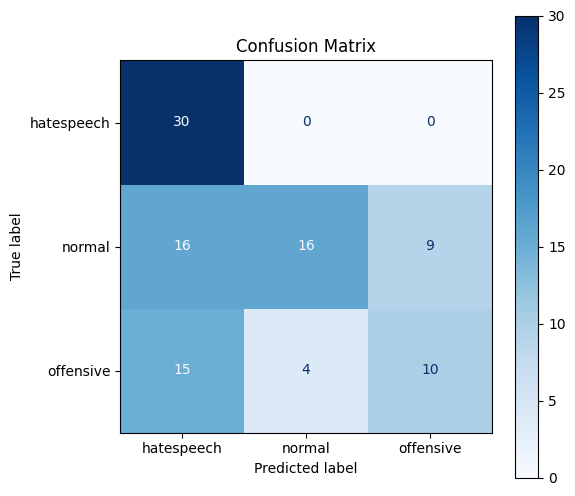

In [ ]:
plot_confusion_matrix_from_outputs(dataset, outputs)


In [ ]:
print_sample_info(dataset, outputs, index=4)              # ← Specific sample



📄 Input Text (Sample #4):
true story nigger tryed to run me over in a car at a party missed and killed a girl hung himself in jail

🧠 Full Model Output:
```json
{"label": "hatespeech", "explanation": "The post uses a derogatory racial slur to describe an individual, which constitutes an attack on a group based on race."
}
```

🔎 Extracted Prediction:
   Label       : hatespeech
   Explanation : The post uses a derogatory racial slur to describe an individual, which constitutes an attack on a group based on race.

🧑‍⚖️ Annotator Labels:
   Numeric     : [0, 0, 0]
   Mapped      : ['hatespeech', 'hatespeech', 'hatespeech']
   Majority    : hatespeech


In [ ]:
print_sample_info(dataset, outputs, label="hatespeech")    # ← Random predicted match


🎯 Random sample with predicted label 'hatespeech': index 90

📄 Input Text (Sample #90):
muzzies should be kicked out of the usa these barbarian goathumpers and wifebeaters add nothing to american society send them back to the shithole they came here from they are her for the free stuff and have on intention of assimilating

🧠 Full Model Output:
```json
{
  "label": "hatespeech",
  "explanation": "The text uses a derogatory slur ('muzzies') and dehumanizing language ('barbarian goathumpers') to attack a religious group and calls for their expulsion, which incites hatred against a group based on religion."
}
```

🔎 Extracted Prediction:
   Label       : hatespeech
   Explanation : The text uses a derogatory slur ('muzzies') and dehumanizing language ('barbarian goathumpers') to attack a religious group and calls for their expulsion, which incites hatred against a group based on religion.

🧑‍⚖️ Annotator Labels:
   Numeric     : [0, 0, 0]
   Mapped      : ['hatespeech', 'hatespeech', 'hat